### Install gensim and spacy, also downgrade scipy to 1.12

In [16]:
#!pip install gensim
#!pip install spacy
#!pip install scipy=1.12

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gensim
from gensim.models.ldamulticore import LdaMulticore
import spacy
from nltk.stem import PorterStemmer
import re
from tqdm import tqdm

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Download the spacy model: run this if you first time using spacy
# spacy.cli.download("en_core_web_sm")

# Load English spacy object as en
en = spacy.load('en_core_web_sm', disable=["parser", "tagger","ner"]) # , disable=["parser", "tagger","ner"]
stopwords = en.Defaults.stop_words

In [19]:
# read the data

transcript_df = pd.read_csv('hw6_demo.csv')

In [20]:
transcript_df

,Unnamed: 0,company_id,date,title,text
0,0,3153,2019-10-01,Acquisition of State Bank Corp by Glacier Ban...,"Ladies and gentlemen, thank you for standing b..."
1,1,94,2019-10-15,Q3 2019 Earnings Call,"Hello, and welcome to Citi's Third Quarter 201..."
2,2,6555,2019-10-15,Q3 2019 Earnings Call,Good morning and welcome to the Mercantile Ban...
3,3,539,2019-10-15,Q3 2019 Earnings Call,"Good morning. My name is Regina, and I will be..."
4,4,288,2019-10-15,Q3 2019 Earnings Call,"Good morning, ladies and gentlemen. Welcome to..."
...,...,...,...,...,...
195,195,8081,2019-11-01,Q3 2019 Earnings Call,"Good morning, and welcome to the Hilltop Holdi..."
196,196,8228,2019-11-01,Q3 2019 Earnings Call,Good morning and welcome to the MoneyGram Inte...
197,197,7933,2019-11-01,Q3 2019 Earnings Call,Greetings and welcome to the Marlin Business S...
198,198,2735,2019-11-04,Q3 2019 Earnings Call,"Good day, everyone, and welcome to the Credit ..."


## Compute # of observations per firm

In [21]:
companies = transcript_df.groupby('company_id')
observations = companies['text'].count()
for n in range(1,4):
    freq = observations.value_counts()
    try:
        number = freq[n]
    except KeyError:
        number = 0
    print(f'{number} companies have {n} observations.')

194 companies have 1 observations.
3 companies have 2 observations.
0 companies have 3 observations.


# Preprocess the Data

In [22]:
# replace non-alphabetical characters with a space
import re
import string

transcript_df['text_1'] = transcript_df['text'].str.replace(':', ' ')
transcript_df['text_1'] = transcript_df['text_1'].str.replace(r'[^A-Za-z ]+', ' ', regex=True)
transcript_df['text_1'] = transcript_df['text_1'].str.lower()   

In [23]:
# Lemmatize the text

text = [t.split() for t in transcript_df.text_1.tolist()]
stemmed_text = []
ps = PorterStemmer()
for sentence in tqdm(text):
    sent = []
    for word in sentence:
        sent.append(ps.stem(word))
    stemmed_text.append(sent)

100%|██████████| 200/200 [00:08<00:00, 23.87it/s]


In [24]:
# create a dictionary and a corpus and remove stopwords

dictionary = gensim.corpora.Dictionary(stemmed_text)

# remove stopwords
stopword_ids = map(dictionary.token2id.get, stopwords)
dictionary.filter_tokens(bad_ids=stopword_ids)
dictionary.filter_extremes(no_below=100, no_above=0.95, keep_n=None)
dictionary.compactify()                                       # remove gaps in id sequence
bow = [dictionary.doc2bow(line) for line in tqdm(stemmed_text)]

100%|██████████| 200/200 [00:00<00:00, 1680.16it/s]


## Draw a histogram for distribution of conference call text (in terms of # of words)

Text(0.5, 1.0, 'Distribution of Length of Conference Call Text')

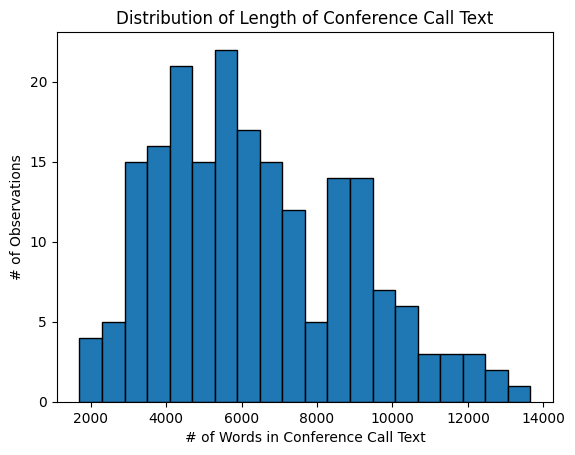

In [25]:
lengths = []
for call in text:
    lengths.append(len(call))

plt.hist(lengths, bins = 20, edgecolor='black')
plt.xlabel('# of Words in Conference Call Text')
plt.ylabel('# of Observations')
plt.title('Distribution of Length of Conference Call Text')

## Do LDA to extract topics

In [26]:
# perform unguided LDA first
lda = LdaMulticore(corpus=bow, id2word=dictionary, num_topics=4, chunksize=2000, passes=5, random_state=42, alpha='symmetric')

In [27]:
# Get the top 10 words for each topic
topic_words = lda.show_topics(10)
print('Top 10 words for each topic:')
for topic_num, topic in topic_words:
    topics = lda.get_topic_terms(topic_num, 10)
    readable = [dictionary[word_id] for word_id, prob in topics]
    print(f'Topic #{topic_num + 1}: {readable}')

Top 10 words for each topic:
Topic #1: ['deposit', 'yeah', 'margin', 'compar', 'morn', 'non', 'capit', 'mean', 'becaus', 'talk']
Topic #2: ['revenu', 'custom', 'yeah', 'deposit', 'invest', 'capit', 'billion', 'line', 'morn', 'higher']
Topic #3: ['deposit', 'morn', 'margin', 'yeah', 'got', 'mayb', 'line', 'compani', 'yield', 'capit']
Topic #4: ['deposit', 'non', 'margin', 'level', 'averag', 'morn', 'yeah', 'commerci', 'compar', 'remain']


In [28]:
# create weight for guided LDA
client = ['consum','payment','client','spend','platform','servic','use','user']
financing = ['loan','leverag','deposit','interest','credit','bank','financi','mortgag','lend','borrow','billion','million']

client = [ps.stem(word) for word in client]
financing = [ps.stem(word) for word in financing]

seed_topics = {}
for word in client:
    seed_topics[word] = 0
for word in financing:
    seed_topics[word] = 1

# Create_eta function gives eta matrix with apriori words in topics. 
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

eta = create_eta(seed_topics, dictionary, 4)

In [29]:
lda_model = LdaMulticore(corpus=bow,
                         id2word=dictionary,
                         num_topics=4,
                         eta=eta,                # pass the eta matrix - weights for the priors if using guided LDA
                         chunksize=2000,
                         passes=5,
                         random_state=42,
                         alpha='symmetric',
                         per_word_topics=True)

In [30]:
# Top 10 words for each topic in guided LDA
topic_words = lda_model.show_topics(10)
print('Top 10 words for each topic (guided LDA):')
for topic_num, topic in topic_words:
    topics = lda_model.get_topic_terms(topic_num, 10)
    readable = [dictionary[word_id] for word_id, prob in topics]
    print(f'Topic #{topic_num}: {readable}')



Top 10 words for each topic (guided LDA):
Topic #0: ['revenu', 'servic', 'custom', 'invest', 'yeah', 'consum', 'line', 'client', 'product', 'talk']
Topic #1: ['deposit', 'mortgag', 'yeah', 'billion', 'morn', 'higher', 'commerci', 'capit', 'margin', 'averag']
Topic #2: ['yeah', 'morn', 'margin', 'got', 'compani', 'deposit', 'capit', 'q', 'mayb', 'mean']
Topic #3: ['deposit', 'non', 'margin', 'compar', 'morn', 'septemb', 'yeah', 'averag', 'level', 'decreas']


We see topic 0, and topic 1, contain more of the seed words for the topics that were used to guide the LDA model.

Topic 0, or Client, contains words lemma words like servic, client, and consum.

And Topic 1, or Financing, contains lemma words like deposit, mortgag, and billion.